# Train

Train models and find optimal parameters using cross validation.

The models are:
1. `Oracle`. Needs no training.
2. `Mean`. Needs no training.
3. `DemWeight`. Learn weights over the training set.
4. `HitWeight`. Optimize `beta` using CV and learn weights.
5. `ScoreWeight`. Optimize `beta` using CV and learn weights.
6. `KDemWeight`. Optimize `k` using CV and learn weights.
7. `MPWeight`. Optimize `eta` using CV.

For all the models with learning requirements, we will use leave one season out cross validation scheme to find optimal parameters and then save a model dump using weights trained from the complete training data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(1234)

import sys
sys.path.append("../src")
from utils import data as udata
from utils import dists as udists
from utils import misc as u
from tqdm import tqdm, trange
import os.path as path
import stringcase
import models
import inspect

In [2]:
EXP_DIR = "../data/processed/cdc-flusight-ensemble/"
OUTPUT_DIR = "../models/cdc-flusight-ensemble/"
TARGET = "1-ahead"
# We use all the regions as of now
REGION = None
# We have training data from the set [2010, 2016]. From these, we use
# [2010, 2013] for training and CV.
TRAINING_SEASONS = list(range(2010, 2014))

In [3]:
components = [udata.Component(EXP_DIR, m) for m in udata.available_models(EXP_DIR)]
ad = udata.ActualData(EXP_DIR)

## Evaluation

We evaluate the models on the left out season and take mean across all such evaluations.

In [9]:
def evaluate_season(model, season):
    """
    Return score and model predictions for given season
    """
    
    yi, Xs, y = udata.get_seasons_data(ad, components, [season], TARGET, REGION)
    predictions = np.zeros_like(Xs[0])

    for i in range(len(yi)):
        # HACK: Check if this is an oracle
        # This should ideally go in as a flag in the model
        if "truth" in inspect.signature(model.predict).parameters:
            # This is an oracle
            predictions[i, :] = model.predict(yi.iloc[i], [X[i] for X in Xs], y[i])
        else:
            predictions[i, :] = model.predict(yi.iloc[i], [X[i] for X in Xs]) 
        # Pass in feedback if model accepts it
        try:
            model.feedback(y[i])
        except NotImplementedError:
            pass

    score = np.log(udists.prediction_probabilities([predictions], y, TARGET)).mean()
    return score, predictions

def cross_validate(model):
    """
    Run cross validation and return mean score
    """
    
    cv_scores = []
    train_scores = []
    for season in tqdm(TRAINING_SEASONS):
        train_seasons = [s for s in TRAINING_SEASONS if s != season]
        yi, Xs, y = udata.get_seasons_data(ad, components, train_seasons, TARGET, REGION)
        model.train(yi, Xs, y)
        for ts in train_seasons:
            score, _= evaluate_season(model, ts)
            train_scores.append(score)
        
        score, _ = evaluate_season(model, season)
        cv_scores.append(score)

    return np.mean(train_scores), np.mean(cv_scores)

def train_and_save(model):
    """
    Train the model on all data and save 
    """
    
    yi, Xs, y = udata.get_seasons_data(ad, components, TRAINING_SEASONS, TARGET, REGION)
    model.train(yi, Xs, y)
    model_file_name = f"{stringcase.spinalcase(type(model).__name__)}.json"
    model.save(path.join(OUTPUT_DIR, TARGET, model_file_name))

# Cross validation

## Oracle model
This is the oracle model which sets the upper limit for prediction

In [11]:
cross_validate(models.OracleEnsemble(TARGET, len(components)))

100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


(-1.8382281857986074, -1.8382281857986071)

## Mean ensemble
Return the mean of component predictions. It kind of sets the lower bar since we should be able to beat the mean at the very least.

In [12]:
cross_validate(models.MeanEnsemble(TARGET, len(components)))

100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


(-2.8105286187289806, -2.8105286187289806)

## Degenerate EM
This trains weights for each component using degenerate EM. It doesn't take into account the current week.

In [13]:
cross_validate(models.DemWeightEnsemble(TARGET, len(components)))

100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


(-2.6409312377432497, -2.659125606739946)

In [15]:
# Save the weights
train_and_save(models.DemWeightEnsemble(TARGET, len(components)))

## K-partition Degenerate EM
Here we partition the list of model weeks in k partitions and run degenerate EM on each of these. While predicting, we check in which partition the instance belongs (using its model week) and then use that partition's weights for generating predictions.

In the case of k = 1, this is equivalent to simple degenerate EM. When k=len(model_weeks), this is equivalent to learning weights per week (this would still not be oracular since, for a week, we might have more instances if we consider more than one region).

In [16]:
cv_scores = []
t_scores = []
for k in range(1, 30):
    ts, cs = cross_validate(models.KDemWeightEnsemble(TARGET, len(components), k))
    cv_scores.append(cs)
    t_scores.append(ts)

100%|██████████| 4/4 [00:21<00:00,  5.32s/it]


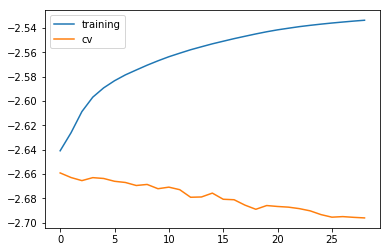

In [17]:
plt.plot(t_scores, label="training")
plt.plot(cv_scores, label="cv")
plt.legend()

In [20]:
# Save the weights
optimal_k = range(1, 30)[np.argmax(cv_scores)]
train_and_save(models.KDemWeightEnsemble(TARGET, len(components), optimal_k))

## Hit weight ensemble
This is a toy model which uses the number of times a model is best (hit) among the lot to assign its weight. Its basically a sharper weight assignment scheme than the score weight ensemble. Additionally, since we have less data (and so the hits are sparse), this model doesn't learn different weights for different model weeks.

In [21]:
cv_scores = []
t_scores = []
betas = np.linspace(0, 0.1, 10)
for beta in betas:
    ts, cs = cross_validate(models.HitWeightEnsemble(TARGET, len(components), beta))
    cv_scores.append(cs)
    t_scores.append(ts)

100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


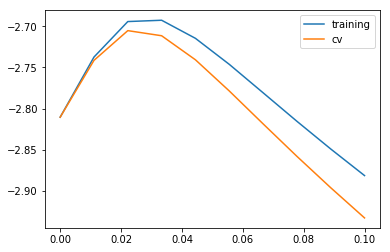

In [22]:
plt.plot(betas, t_scores, label="training")
plt.plot(betas, cv_scores, label="cv")
plt.legend()

In [23]:
# Save the weights
optimal_beta = betas[np.argmax(cv_scores)]
train_and_save(models.HitWeightEnsemble(TARGET, len(components), optimal_beta))

## Score weight ensemble
Here we learn one set of weights for each model week using the value of model score.

In [25]:
cv_scores = []
t_scores = []
betas = np.linspace(1, 5, 5)
for beta in betas:
    ts, cs = cross_validate(models.ScoreWeightEnsemble(TARGET, len(components), beta))
    cv_scores.append(cs)
    t_scores.append(ts)

100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


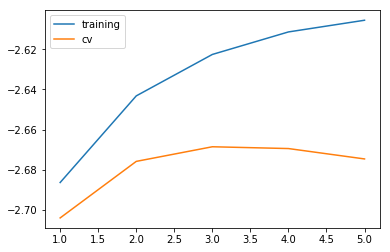

In [26]:
plt.plot(betas, t_scores, label="training")
plt.plot(betas, cv_scores, label="cv")
plt.legend()

In [27]:
# Save the weights
optimal_beta = betas[np.argmax(cv_scores)]
train_and_save(models.ScoreWeightEnsemble(TARGET, len(components), optimal_beta))

## Multiplicative weight
This adapts the model weights according to past performance by hedging.

In [29]:
# TODO: Fix underflow
cv_scores = []
t_scores = []
etas = np.linspace(0, 2, 20)
for eta in etas:
    ts, cs = cross_validate(models.MPWeightEnsemble(TARGET, len(components), eta))
    cv_scores.append(cs)
    t_scores.append(ts)

100%|██████████| 4/4 [00:06<00:00,  1.63s/it]


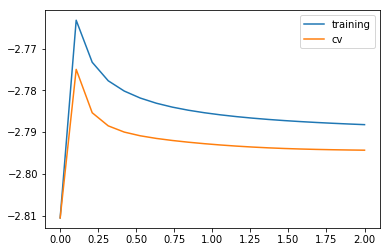

In [30]:
plt.plot(etas, t_scores, label="training")
plt.plot(etas, cv_scores, label="cv")
plt.legend()

In [32]:
# Save the weights
optimal_eta = etas[np.argmax(cv_scores)]
train_and_save(models.MPWeightEnsemble(TARGET, len(components), optimal_eta))